In [1]:
import os 
import pandas as pd
import glob 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np

os.chdir('/mnt/BioHome/jreyna/jreyna/projects/dchallenge/')

outdir = 'results/notebooks/colocalization_with_eqtl_catalogue/'
os.makedirs(outdir, exist_ok=True)

## Loading the gencode reference

In [2]:
gencode = pd.read_table('results/refs/gencode/v30/gencode.v30.annotation.bed', header=None)
gencode = gencode.iloc[:, [5,6]]
gencode.set_index(6, inplace=True)
gencode = gencode.squeeze()
gencode = gencode.to_dict()
rev_gencode = {v:k for k,v in gencode.items()}

## Loading and processing the coloc data 

In [3]:
data = []
coloc_glob = 'results/main/coloc/Results/eQTL_Catalogue/T1D_34012112_Gaulton/*/*/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed'
coloc_fns = sorted(glob.glob(coloc_glob))
coloc_fns = [x for x in coloc_fns if 'test' not in x]
old_colocs = 17 #en(coloc_fns)
print('Number of colocalizations analyses: {}.'.format(len(coloc_fns)))

Number of colocalizations analyses: 20.


In [4]:
for fn in coloc_fns:
    
    # load the data
    df = pd.read_table(fn)
    
    # get GWAS, eQTL and gene expression sources
    fname_segs = fn.split('/')
    gwas = fname_segs[5]
    eqtl = fname_segs[6]
    ge = fname_segs[7]
    
    # assign the current values
    df['gwas'] = gwas
    df['eqtl'] = eqtl
    df['ge'] = ge
    data.append(df)
    
t1d_data = pd.concat(data)

In [5]:
# add the gene name
t1d_data['gene_name'] = t1d_data.geneName.replace(rev_gencode)

In [6]:
# removing duplicate SNP-gene pairs by find the one with the largest PP4
t1d_data_rgs = t1d_data.groupby(['gwas', 'eqtl', 'ge', 'rs_id', 'geneName'])
new_t1d_data = []
for grp, grp_df in t1d_data_rgs:
    max_index = np.argmax(grp_df.pp_H4_Coloc_Summary)
    new_t1d = grp_df.iloc[max_index,:]
    new_t1d_data.append(new_t1d)
new_t1d_data = pd.DataFrame(new_t1d_data)
new_t1d_data.reset_index(drop=True, inplace=True)

# assigning t1d_data to the new dataset
t1d_data = new_t1d_data.copy()

In [7]:
# creating a list of the most important columns 
major_cols = ['chr', 'pos','rs_id', 'variant_id', 'gene_name','pp_H4_Coloc_Summary', 'dist', 'pvalue', 'FDR', 'slope_snp',
       'slope_se_snp', 'slope_gwas', 'slope_se_gwas', 'pval_nominal', 'SampleSize', 'gwas', 'eqtl', 'ge',
       'geneName']

# generating a dataframe the the most important columns
t1d_data = t1d_data[major_cols]

# renaming these columns for easier understanding
major_renames = {
    'chr': 'chr',
    'pos': 'pos',
    'rs_id': 'rsid',
    'variant_id': 'varid',
    'gene_name': 'genename',
    'pp_H4_Coloc_Summary': 'ppH4',
    'dist': 'sg_dist',
    'pvalue': 'eqtl_pval',
    'FDR': 'eqtl_fdr',
    'slope_snp': 'eqtl_slope',
    'slope_se_snp': 'eqtl_slope_se',
    'slope_gwas': 'gwas_slope',
    'slope_se_gwas': 'gwas_slope_se',
    'pval_nominal': 'gwas_pval',
    'SampleSize': 'gwas_sample_size',
    'gwas': 'gwas_source',
    'eqtl': 'eqtl_source',
    'ge': 'ge_source',
    'geneName': 'gene_id'}
major_cols = [major_renames[x] for x in major_cols]
t1d_data.rename(columns=major_renames, inplace=True)

### Checking genes which are significant (FDR<0.05)

In [8]:
sig_eqtls = t1d_data[major_cols].\
                        sort_values(['eqtl_source', 'ge_source', 'rsid']).\
                        set_index(['eqtl_source', 'ge_source', 'rsid'])
sig_eqtls = sig_eqtls[sig_eqtls.eqtl_fdr < 0.05]

In [9]:
sig_eqtls

chr       pos  \
eqtl_source    ge_source                rsid                          
BLUEPRINT      T-cell                   rs1788229   chr18  69866725   
Quach_2016     monocyte_R848            rs17207042  chr18  69870115   
Schmiedel_2018 CD4_T-cell_anti-CD3-CD28 rs36024512  chr18  69855122   
               Tfh_memory               rs3825932   chr15  78943104   
               Th1-17_memory            rs1788105   chr18  69865056   
               Treg_naive               rs3018275   chr18  69858621   

                                                               varid  \
eqtl_source    ge_source                rsid                           
BLUEPRINT      T-cell                   rs1788229    18:69866725:T:G   
Quach_2016     monocyte_R848            rs17207042   18:69870115:T:C   
Schmiedel_2018 CD4_T-cell_anti-CD3-CD28 rs36024512  18:69855122:C:CA   
               Tfh_memory               rs3825932    15:78943104:T:C   
               Th1-17_memory            rs1788105    18:69865056:A:G   
               Treg_naive               rs3018275    18:69858621:C:T   

                                                      genename      ppH4  \
eqtl_source    ge_source                rsid                               
BLUEPRINT      T-cell                   rs1788229   AC068254.1  0.867116   
Quach_2016     monocyte_R848            rs17207042        DOK6  0.904612   
Schmiedel_2018 CD4_T-cell_anti-CD3-CD28 rs36024512        DOK6  0.850650   
               Tfh_memory               rs3825932   AC027228.1  0.794168   
               Th1-17_memory            rs1788105   AC068254.1  0.842424   
               Treg_naive               rs3018275         DOK6  0.841050   

                                                    sg_dist     eqtl_pval  \
eqtl_source    ge_source                rsid                                
BLUEPRINT      T-cell                   rs1788229    141750  3.615440e-11   
Quach_2016     monocyte_R848            rs17207042   469227  7.026230e-07   
Schmiedel_2018 CD4_T-cell_anti-CD3-CD28 rs36024512   454234  7.785780e-08   
               Tfh_memory               rs3825932    461284  1.320460e-04   
               Th1-17_memory            rs1788105    140081  5.771950e-11   
               Treg_naive               rs3018275    457733  1.243620e-07   

                                                        eqtl_fdr  eqtl_slope  \
eqtl_source    ge_source                rsid                                   
BLUEPRINT      T-cell                   rs1788229   1.318455e-08   -0.564373   
Quach_2016     monocyte_R848            rs17207042  3.023241e-04   -0.407996   
Schmiedel_2018 CD4_T-cell_anti-CD3-CD28 rs36024512  7.831363e-05   -0.722322   
               Tfh_memory               rs3825932   3.757723e-02   -0.564040   
               Th1-17_memory            rs1788105   1.155408e-07   -0.885223   
               Treg_naive               rs3018275   1.115125e-04   -0.527773   

                                                    eqtl_slope_se  gwas_slope  \
eqtl_source    ge_source                rsid                                    
BLUEPRINT      T-cell                   rs1788229        0.002109   -0.102254   
Quach_2016     monocyte_R848            rs17207042       0.004730   -0.100640   
Schmiedel_2018 CD4_T-cell_anti-CD3-CD28 rs36024512       0.001145   -0.111631   
               Tfh_memory               rs3825932        0.002472    0.122010   
               Th1-17_memory            rs1788105        0.000626   -0.102549   
               Treg_naive               rs3018275        0.002469   -0.102841   

                                                    gwas_slope_se  \
eqtl_source    ge_source                rsid                        
BLUEPRINT      T-cell                   rs1788229        0.014003   
Quach_2016     monocyte_R848            rs17207042       0.013979   
Schmiedel_2018 CD4_T-cell_anti-CD3-CD28 rs36024512       0.014952   
               Tfh_memory               rs38259

## Checking the data sources

In [10]:
check_sources = t1d_data.drop_duplicates(['eqtl_source', 'ge_source'])
check_sources = check_sources[['eqtl_source', 'ge_source']]

In [11]:
pd.set_option('display.max_rows', 100) 
display(check_sources.set_index('eqtl_source'))
pd.set_option('display.max_rows', 20) 

,ge_source
eqtl_source,
BLUEPRINT,T-cell
BLUEPRINT,monocyte
BLUEPRINT,neutrophil
GTEx,LCL
Quach_2016,monocyte_IAV
Quach_2016,monocyte_Pam3CSK4
Quach_2016,monocyte_R848
Schmiedel_2018,B-cell_naive
Schmiedel_2018,CD4_T-cell_anti-CD3-CD28


## Plotting the Number of SNP-Gene Pairs

In [12]:
study_summary = t1d_data.value_counts(['gwas_source', 'eqtl_source', 'ge_source']).to_frame().reset_index()
study_summary.rename(columns={0:'count'}, inplace=True)

In [13]:
print('The median number of colocalizations per study is {}.'.format(study_summary['count'].median()))

The median number of colocalizations per study is 2.0.


Text(19.015271086516208, 0.5, 'Count')

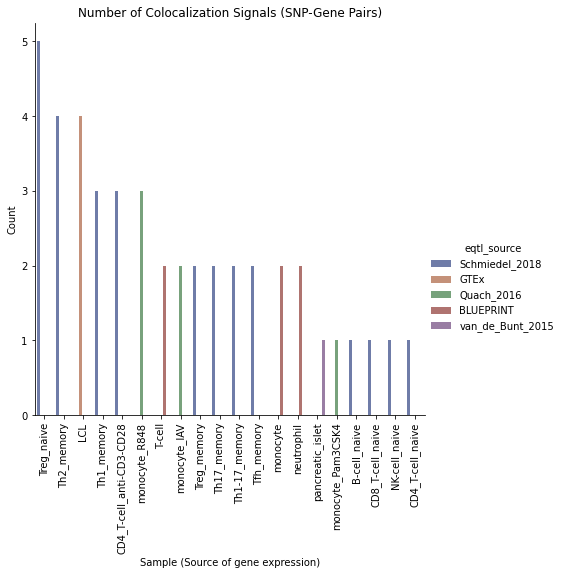

In [14]:
#sns.barplot(hue='eqtl', y='count', x='ge', data=study_summary)

# fig, ax = plt.subplots()
# Draw a nested barplot by species and sex
g= sns.catplot(data=study_summary, kind="bar",
            x="ge_source", y="count", hue="eqtl_source",
            ci="sd", palette="dark", alpha=.6, height=6)

for x in g.ax.get_xticklabels():
    x.set_rotation(90)
    
g.ax.set_title('Number of Colocalization Signals (SNP-Gene Pairs)')
g.ax.set_xlabel('Sample (Source of gene expression)')
g.ax.set_ylabel('Count')

In [15]:
study_report_fn = os.path.join(outdir, 'coloc_report.tsv')
study_summary.to_csv(study_report_fn, sep='\t', index=False)

## Plotting the Number of Unique Genes per Colocalization Analysis

In [16]:
uniq_genes_per_sample = t1d_data.groupby(['eqtl_source', 'ge_source']).genename.nunique()
uniq_genes_per_sample = uniq_genes_per_sample.reset_index()

Text(14.116854745370379, 0.5, 'Count')

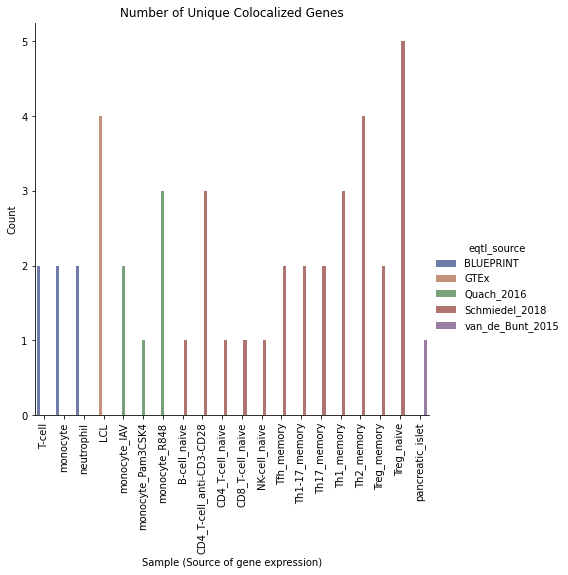

In [17]:
#sns.barplot(hue='eqtl', y='count', x='ge', data=study_summary)

# fig, ax = plt.subplots()
# Draw a nested barplot by species and sex
g= sns.catplot(data=uniq_genes_per_sample, kind="bar",
            x="ge_source", y="genename", hue="eqtl_source",
            ci="sd", palette="dark", alpha=.6, height=6)

for x in g.ax.get_xticklabels():
    x.set_rotation(90)
    
g.ax.set_title('Number of Unique Colocalized Genes')
g.ax.set_xlabel('Sample (Source of gene expression)')
g.ax.set_ylabel('Count')

In [18]:
# find the uniq snps
uniq_snps_per_samples = t1d_data.groupby(['eqtl_source', 'ge_source']).rsid.nunique().reset_index()

In [19]:
# concat the two tables
uniq_summary = uniq_genes_per_sample.merge(uniq_snps_per_samples)
uniq_summary.columns = ['eqtl', 'ge', 'Unique # Genes', 'Unique # SNPs']

### Table for the number of unique genes and snps per colocalization analyses

In [20]:
pd.set_option('display.max_rows', 100) 
display(uniq_summary.sort_values('Unique # SNPs', ascending=False))
pd.set_option('display.max_rows', 20) 

,eqtl,ge,Unique # Genes,Unique # SNPs
18,Schmiedel_2018,Treg_naive,5,5
3,GTEx,LCL,4,4
16,Schmiedel_2018,Th2_memory,4,4
6,Quach_2016,monocyte_R848,3,3
8,Schmiedel_2018,CD4_T-cell_anti-CD3-CD28,3,3
15,Schmiedel_2018,Th1_memory,3,3
0,BLUEPRINT,T-cell,2,2
14,Schmiedel_2018,Th17_memory,2,2
2,BLUEPRINT,neutrophil,2,2
4,Quach_2016,monocyte_IAV,2,2


## Summarizing the Unique Genes Combined Across all Colocalization Analyses

In [21]:
# construct a table of unique genes 
gene_uniq_summary = t1d_data.drop_duplicates(['eqtl_source', 'ge_source', 'genename']).genename.value_counts()
gene_uniq_summary = gene_uniq_summary.to_frame()
gene_uniq_summary.sort_values('genename', ascending=False, inplace=True)
gene_uniq_summary.columns = ['Number of Unique Colocalizations per Gene in ALL Studies']

print('There are {} unique genes in the whole dataset.'.format(gene_uniq_summary.shape[0]))

# display this table
pd.set_option('display.max_rows', gene_uniq_summary.shape[0]) 
display(gene_uniq_summary)
pd.set_option('display.max_rows', 20) 

There are 31 unique genes in the whole dataset.


,Number of Unique Colocalizations per Gene in ALL Studies
GLIS3,4
DOK6,3
LINC01031,3
AL163932.1,2
NPIPB15,2
AL359317.1,2
AC008063.1,2
AL354760.1,2
AC068254.1,2
LINC02320,1


In [22]:
# save an enrichr file 
enrichr_fn = os.path.join(outdir, 'enrichr.input.txt')
with open(enrichr_fn, 'w') as fw:
    for x in sorted(gene_uniq_summary.index.tolist()):
        print(x, file=fw)
        print(x)

AC008063.1
AC008063.2
AC016747.2
AC027228.1
AC068254.1
AC091563.1
ACTA2
AL133370.1
AL133445.2
AL137856.1
AL157394.2
AL157871.5
AL163932.1
AL354760.1
AL354977.2
AL359317.1
CACHD1
DOK6
DPP4
DSCC1
GLIS3
HUS1B
IRF4
LINC01031
LINC02285
LINC02320
NPIPB15
RGS1
ROR1
TNFRSF11B
TRIM61


## Quick Dive into Treg Naive Colocalizations

In [23]:
treg = t1d_data.loc[t1d_data['ge_source'] == 'Treg_naive', :]
treg.sort_values(['chr', 'pos'], inplace=True)

/mnt/BioHome/jreyna/software/anaconda3/envs/hic_tls/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
treg[major_cols]

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_sample_size,gwas_source,eqtl_source,ge_source,gene_id
41,chr1,113285485,rs773560,1:113285485:G:A,AL137856.1,0.978083,526894,2.323010e-02,0.632393,-0.438205,0.004354,0.168861,0.015663,4.230000e-27,520580,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000231128
38,chr1,192546719,rs10801128,1:192546719:A:G,RGS1,0.865499,29044,1.363810e-02,0.541238,0.225144,0.016133,0.096073,0.015681,8.980000e-10,520580,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000090104
42,chr14,98019683,rs922406,14:98019683:T:C,AL163932.1,0.787636,185460,9.708230e-03,0.481031,-0.493646,0.002879,-0.092793,0.015229,1.110000e-09,520580,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000259097
40,chr18,69858621,rs3018275,18:69858621:C:T,DOK6,0.841050,457733,1.243620e-07,0.000112,-0.527773,0.002469,-0.102841,0.014026,2.260000e-13,520580,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000206052
39,chr2,60422008,rs12997266,2:60422008:G:A,AC016747.2,0.754330,740097,2.485170e-02,0.643440,-0.368777,0.009128,-0.087489,0.014351,1.090000e-09,520580,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000271889


## Quick Dive into GLIS3

Very lowly expressed according to DICE: https://dice-database.org/genes/GLIS3 and eQTL FDR is not significant. 

In [25]:
t1d_data.loc[t1d_data['genename'] == 'GLIS3', major_cols]

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_sample_size,gwas_source,eqtl_source,ge_source,gene_id
4,chr9,4290823,rs6476839,9:4290823:A:T,GLIS3,0.809271,57569,0.010269,0.242092,-0.338403,0.006585,0.123270,0.014153,3.040000e-18,520580,T1D_34012112_Gaulton,BLUEPRINT,neutrophil,ENSG00000107249
10,chr9,4296430,rs10814917,9:4296430:A:G,GLIS3,0.759110,51962,0.057347,0.713889,-0.274822,0.012701,-0.119714,0.013994,1.180000e-17,520580,T1D_34012112_Gaulton,Quach_2016,monocyte_IAV,ENSG00000107249
12,chr9,4296430,rs10814917,9:4296430:A:G,GLIS3,0.776345,51962,0.027644,0.568634,-0.325938,0.008901,-0.119714,0.013994,1.180000e-17,520580,T1D_34012112_Gaulton,Quach_2016,monocyte_Pam3CSK4,ENSG00000107249
15,chr9,4282536,rs4380994,9:4282536:A:G,GLIS3,0.806803,65856,0.006440,0.336787,-0.407677,0.005361,-0.121582,0.013995,3.710000e-18,520580,T1D_34012112_Gaulton,Quach_2016,monocyte_R848,ENSG00000107249
